# 유의판매자 분석 EDA

## 유의판매자 기준
1. **리뷰 평균별점 & 1,2점(low) 리뷰 비율** - 낮은 평점, 높은 저점 비율
2. **제품 상세정보 부실** - 사진 개수 0개 또는 설명 없음
3. **주문 방치** - 주문 접수 후 7일 이상 출고 안됨
4. **결제 승인 소요시간** - 4일 이상 소요
5. ~~**배송지연** - 예상 배송일 대비 지연일 초과~~
6. ~~**카테고리별 처리 속도** - 동일 카테고리 내 상대적으로 느린 처리~~

### 분석 조건
- 실제 텍스트 리뷰를 남긴 주문만 분석 대상
- 불완전 기간 데이터 제외 (2016년 9~12월, 2018년 9~11월)


In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

orders = pd.read_csv('Olist_DataSet/olist_orders_dataset.csv')
order_items = pd.read_csv('Olist_DataSet/olist_order_items_dataset.csv')
sellers = pd.read_csv('Olist_DataSet/olist_sellers_dataset.csv')
products = pd.read_csv('Olist_DataSet/olist_products_dataset.csv')
reviews = pd.read_csv('Olist_DataSet/olist_order_reviews_dataset.csv')
category_trans = pd.read_csv('Olist_DataSet/product_category_name_translation.csv')

print(f"주문 데이터: {len(orders):,}건")
print(f"주문 아이템: {len(order_items):,}건")
print(f"판매자: {len(sellers):,}명")
print(f"상품: {len(products):,}개")
print(f"리뷰: {len(reviews):,}건")


주문 데이터: 99,441건
주문 아이템: 112,650건
판매자: 3,095명
상품: 32,951개
리뷰: 99,224건


In [408]:
print("=" * 70)
print("데이터 전처리 - 불완전 기간 & 이상 데이터 제외")
print("=" * 70)

# 날짜 컬럼 변환
date_cols = ['order_purchase_timestamp', 'order_approved_at', 
             'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date']

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col])

print(f"전체 주문 수: {len(orders):,}")

# ==========================================
# 불완전한 기간 데이터 제외
# - 2016년 9월 ~ 12월
# - 2018년 9월 ~ 11월
# ==========================================
exclude_periods = (
    ((orders['order_purchase_timestamp'].dt.year == 2016) & 
     (orders['order_purchase_timestamp'].dt.month >= 9)) |
    ((orders['order_purchase_timestamp'].dt.year == 2018) & 
     (orders['order_purchase_timestamp'].dt.month >= 9))
)

excluded_orders = orders[exclude_periods]
print(f"제외된 주문 수 (불완전 기간): {len(excluded_orders):,}")

orders = orders[~exclude_periods].copy()
print(f"필터링 후 주문 수: {len(orders):,}")


데이터 전처리 - 불완전 기간 & 이상 데이터 제외
전체 주문 수: 99,441
제외된 주문 수 (불완전 기간): 349
필터링 후 주문 수: 99,092


In [409]:
# 이상 데이터 탐지 및 제외
anomalies = {}

# 1. 운송업체 인수일 > 고객 배송 완료일
anomalies['1'] = orders[
    (orders['order_delivered_carrier_date'].notna()) & 
    (orders['order_delivered_customer_date'].notna()) &
    (orders['order_delivered_carrier_date'] > orders['order_delivered_customer_date'])
]

# 2. 주문 승인일 > 운송업체 인수일
anomalies['2'] = orders[
    (orders['order_approved_at'].notna()) & 
    (orders['order_delivered_carrier_date'].notna()) &
    (orders['order_approved_at'] > orders['order_delivered_carrier_date'])
]

# 3. 배송완료 상태인데 배송일 없음
anomalies['3'] = orders[
    (orders['order_status'] == 'delivered') & 
    (orders['order_delivered_customer_date'].isna())
]

# 4. 미배송 상태인데 배송일 존재
anomalies['4'] = orders[
    (orders['order_status'] != 'delivered') & 
    (orders['order_delivered_customer_date'].notna())
]

# 중복 제거
all_anomaly_ids = set()
for name, df in anomalies.items():
    all_anomaly_ids.update(df['order_id'].tolist())

print(f"총 이상 데이터 고유 주문 수: {len(all_anomaly_ids):,}건")

# 이상 데이터 제외
orders = orders[~orders['order_id'].isin(all_anomaly_ids)].copy()
print(f"이상 데이터 제외 후 주문 수: {len(orders):,}")

# 다른 테이블도 필터링
valid_order_ids = orders['order_id'].unique()
order_items = order_items[order_items['order_id'].isin(valid_order_ids)].copy()
reviews = reviews[reviews['order_id'].isin(valid_order_ids)].copy()

print(f"\n필터링 후 주문 아이템: {len(order_items):,}건")
print(f"필터링 후 리뷰: {len(reviews):,}건")


총 이상 데이터 고유 주문 수: 1,387건
이상 데이터 제외 후 주문 수: 97,705

필터링 후 주문 아이템: 110,674건
필터링 후 리뷰: 97,498건


In [410]:
# ==========================================
# 텍스트 리뷰가 있는 주문만 필터링 (김우주 의견)
# ==========================================
print("=" * 70)
print("3. 텍스트 리뷰 필터링")
print("=" * 70)

print(f"\n전체 리뷰 수: {len(reviews):,}")

# 리뷰 텍스트 컬럼 확인
print(f"\n리뷰 텍스트 결측치:")
print(f"  - review_comment_title: {reviews['review_comment_title'].isna().sum():,}건")
print(f"  - review_comment_message: {reviews['review_comment_message'].isna().sum():,}건")

# 텍스트 리뷰가 있는 리뷰만 필터링 (제목 또는 메시지가 있는 경우)
reviews_with_text = reviews[
    (reviews['review_comment_title'].notna()) | 
    (reviews['review_comment_message'].notna())
].copy()

print(f"\n텍스트 리뷰가 있는 리뷰: {len(reviews_with_text):,}건")
print(f"텍스트 리뷰 비율: {len(reviews_with_text)/len(reviews)*100:.1f}%")

# 텍스트 리뷰 점수 분포
display(reviews_with_text['review_score'].value_counts().sort_index())


3. 텍스트 리뷰 필터링

전체 리뷰 수: 97,498

리뷰 텍스트 결측치:
  - review_comment_title: 86,370건
  - review_comment_message: 57,312건

텍스트 리뷰가 있는 리뷰: 41,846건
텍스트 리뷰 비율: 42.9%


review_score
1     8648
2     2127
3     3581
4     6142
5    21348
Name: count, dtype: int64

---
## 텍스트 리뷰 유무에 따른 비교 분석
텍스트 리뷰가 있는 경우와 없는 경우의 차이를 분석


In [411]:
# ==========================================
# 텍스트 리뷰 유무 그룹 분리
# ==========================================
print("=" * 70)
print("텍스트 리뷰 유무 비교 분석")
print("=" * 70)

# 텍스트 리뷰 유무 플래그 추가
reviews['has_text'] = (
    reviews['review_comment_title'].notna() | 
    reviews['review_comment_message'].notna()
)

# 텍스트 리뷰 없는 리뷰
reviews_without_text = reviews[~reviews['has_text']].copy()

print(f"\n전체 리뷰 현황:")
print(f"  - 전체 리뷰: {len(reviews):,}건")
print(f"  - 텍스트 리뷰 있음: {len(reviews_with_text):,}건 ({len(reviews_with_text)/len(reviews)*100:.1f}%)")
print(f"  - 텍스트 리뷰 없음: {len(reviews_without_text):,}건 ({len(reviews_without_text)/len(reviews)*100:.1f}%)")


텍스트 리뷰 유무 비교 분석

전체 리뷰 현황:
  - 전체 리뷰: 97,498건
  - 텍스트 리뷰 있음: 41,846건 (42.9%)
  - 텍스트 리뷰 없음: 55,652건 (57.1%)


In [ ]:
# ==========================================
# 점수 분포 비교 (텍스트 리뷰 유무)
# ==========================================
print("\n리뷰 점수 분포 비교:")
print("-" * 50)

# 각 그룹의 점수 분포
with_text_dist = reviews_with_text['review_score'].value_counts().sort_index()
without_text_dist = reviews_without_text['review_score'].value_counts().sort_index()

# 비율로 변환
with_text_pct = with_text_dist / len(reviews_with_text) * 100
without_text_pct = without_text_dist / len(reviews_without_text) * 100

comparison_df = pd.DataFrame({
    '텍스트O (건수)': with_text_dist,
    '텍스트O (비율%)': with_text_pct.round(1),
    '텍스트X (건수)': without_text_dist,
    '텍스트X (비율%)': without_text_pct.round(1),
})
display(comparison_df)

# 평균 점수 비교
print(f"\n평균 점수 비교:")
print(f"  - 텍스트 리뷰 있음: {reviews_with_text['review_score'].mean():.2f}점")
print(f"  - 텍스트 리뷰 없음: {reviews_without_text['review_score'].mean():.2f}점")
print(f"  - 차이: {reviews_with_text['review_score'].mean() - reviews_without_text['review_score'].mean():.2f}점")


리뷰 점수 분포 비교:
--------------------------------------------------


,텍스트O (건수),텍스트O (비율%),텍스트X (건수),텍스트X (비율%)
review_score,,,,
1,8648,20.7,2570,4.6
2,2127,5.1,972,1.7
3,3581,8.6,4493,8.1
4,6142,14.7,12674,22.8
5,21348,51.0,34943,62.8



평균 점수 비교:
  - 텍스트 리뷰 있음: 3.70점
  - 텍스트 리뷰 없음: 4.37점
  - 차이: -0.67점


In [413]:
# 통계적 검정: 두 그룹의 차이가 유의미한가?
from scipy import stats

print("=" * 70)
print("통계적 검정: 텍스트 리뷰 유무에 따른 점수 차이")
print("=" * 70)

# Mann-Whitney U 검정 (비모수 검정)
stat, p_value = stats.mannwhitneyu(
    reviews_with_text['review_score'], 
    reviews_without_text['review_score'],
    alternative='two-sided'
)

print(f"\nMann-Whitney U 검정:")
print(f"  - U 통계량: {stat:,.0f}")
print(f"  - p-value: {p_value:.2e}")
print(f"  - 결론: {'두 그룹 간 유의미한 차이 있음 (p < 0.05)' if p_value < 0.05 else '유의미한 차이 없음'}")

# 카이제곱 검정 (점수 분포 독립성)
contingency = pd.crosstab(reviews['has_text'], reviews['review_score'])
chi2, p_chi, dof, expected = stats.chi2_contingency(contingency)

print(f"\n카이제곱 검정 (점수 분포 독립성):")
print(f"  - 카이제곱 통계량: {chi2:,.2f}")
print(f"  - p-value: {p_chi:.2e}")
print(f"  - 자유도: {dof}")
print(f"  - 결론: {'점수 분포가 텍스트 유무에 따라 다름 (p < 0.05)' if p_chi < 0.05 else '점수 분포 독립'}")


통계적 검정: 텍스트 리뷰 유무에 따른 점수 차이

Mann-Whitney U 검정:
  - U 통계량: 941,691,548
  - p-value: 0.00e+00
  - 결론: 두 그룹 간 유의미한 차이 있음 (p < 0.05)

카이제곱 검정 (점수 분포 독립성):
  - 카이제곱 통계량: 7,574.46
  - p-value: 0.00e+00
  - 자유도: 4
  - 결론: 점수 분포가 텍스트 유무에 따라 다름 (p < 0.05)


#### Mann-Whitney U 검정 (순위 비교)
- U 통계량 (941,691,548)
  - 의미: "순위 싸움의 총점"입니다.
  - 해석: 두 그룹(텍스트 있음 vs 없음)의 데이터를 한 줄로 세워 등수를 매겼을 때, 한쪽 그룹이 이긴 횟수(순위 합)를 다 더한 값입니다.
숫자가 9억이나 되는 이유는 단순히 **데이터 개수(행의 수)** 가 많기 때문입니다. 이 숫자 자체의 크기보다는, 이 숫자를 통해 계산된 p-value가 중요합니다. (그냥 "데이터가 많구나" 하고 넘어가도 됩니다.)
- p-value (0.00e+00)
  - 의미: "이 결과가 우연히 나왔을 확률"입니다.
  - 해석: 0.00e+00은 0이라는 뜻입니다. 즉, 우연일 확률이 0%입니다.
"텍스트 리뷰가 있는 점수와 없는 점수는 확실히 다르다."라고 100% 확신을 갖고 결론을 내리시면 됩니다.
#### 카이제곱 검정 (분포 비교)
- 카이제곱 통계량 (7,574.46)
  - 의미: "기대했던 것과 실제 결과의 괴리감(차이)의 크기"입니다.
  - 해석: 만약 두 그룹의 분포가 비슷했다면 이 숫자는 0에 가까웠을 겁니다. 하지만 7,500이 넘었다는 건, 기대와 현실이 엄청나게 다르다는 뜻입니다.
통계적으로 보통 이 수치가 9.49만 넘어도 "유의미하다"고 보는데, 7,574가 나왔다는 건 **"텍스트 유무에 따라 점수 주는 패턴이 완전히 딴판이다"** 라는 강력한 증거입니다.
- p-value (0.00e+00)
  - 의미: 위와 동일하게 "우연일 확률"입니다.
  - 해석: 점수 분포가 다른 것이 절대 우연이 아님을 증명합니다.
- 자유도 (4)
  - 의미: "우리가 비교한 판(Table)의 크기"를 나타내는 숫자입니다.
계산법: (그룹 수 - 1) × (점수 칸 수 - 1)
그룹: 텍스트 있음 / 없음 (2개) → 2−1=1
점수: 1점, 2점, 3점, 4점, 5점 (5개) → 5−1=4
결국 1×4=4
이 숫자가 4가 나왔다는 건, 코드가 "2개 그룹(유/무)과 5개 점수 구간"을 정확하게 인식해서 분석했다는 뜻입니다. (데이터가 올바르게 들어갔는지 확인하는 용도입니다.)

In [414]:
# 종합 데이터 셋 생성

# 상품에 카테고리 영문명 추가
products = products.merge(category_trans, on='product_category_name', how='left')

# 주문 + 아이템 + 판매자 + 상품 병합
order_seller_product = order_items.merge(orders, on='order_id', how='inner')
order_seller_product = order_seller_product.merge(sellers, on='seller_id', how='left')
order_seller_product = order_seller_product.merge(products, on='product_id', how='left')

# 텍스트 리뷰와 병합
df_analysis = order_seller_product.merge(
    reviews_with_text[['order_id', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message']],
    on='order_id',
    how='inner'
)

---
## 유의판매자 기준 1: 리뷰 평균별점 & 1,2점(Low) 리뷰 비율


In [415]:
# 판매자별 리뷰 점수 분석
print("=" * 70)
print("유의판매자 기준 1: 리뷰 평균별점 & 1,2점 리뷰 비율")
print("=" * 70)

# 판매자별 리뷰 통계 계산
seller_review_stats = df_analysis.groupby('seller_id').agg(
    리뷰수=('review_id', 'nunique'),
    평균별점=('review_score', 'mean'),
    별점_표준편차=('review_score', 'std'),
    별점_1점=('review_score', lambda x: (x == 1).sum()),
    별점_2점=('review_score', lambda x: (x == 2).sum()),
    별점_3점=('review_score', lambda x: (x == 3).sum()),
    별점_4점=('review_score', lambda x: (x == 4).sum()),
    별점_5점=('review_score', lambda x: (x == 5).sum()),
).reset_index()

# 1,2점 비율 계산
seller_review_stats['low_review_count'] = seller_review_stats['별점_1점'] + seller_review_stats['별점_2점']
seller_review_stats['low_review_ratio'] = seller_review_stats['low_review_count'] / seller_review_stats['리뷰수']

print(f"\n분석 대상 판매자 수: {len(seller_review_stats):,}명")
print(f"\n판매자별 리뷰 수 통계:")
display(seller_review_stats['리뷰수'].describe())

print(f"\n평균 별점 통계:")
display(seller_review_stats['평균별점'].describe())


유의판매자 기준 1: 리뷰 평균별점 & 1,2점 리뷰 비율

분석 대상 판매자 수: 2,555명

판매자별 리뷰 수 통계:


count    2555.000000
mean       16.482975
std        50.538564
min         1.000000
25%         2.000000
50%         4.000000
75%        12.000000
max       932.000000
Name: 리뷰수, dtype: float64


평균 별점 통계:


count    2555.000000
mean        3.593614
std         1.160890
min         1.000000
25%         3.000000
50%         3.800000
75%         4.500000
max         5.000000
Name: 평균별점, dtype: float64

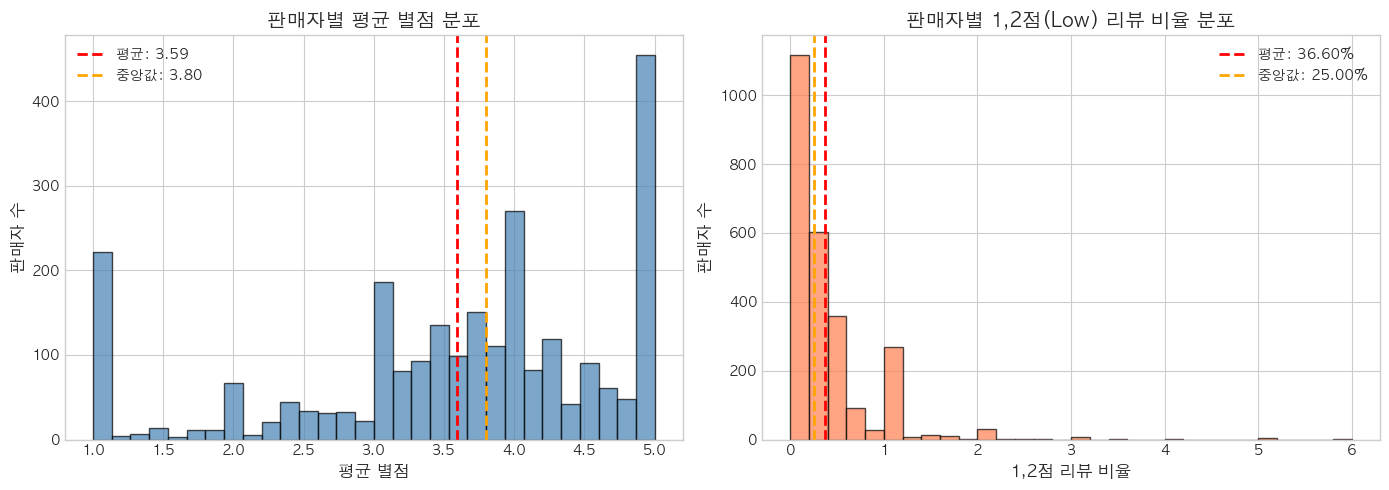

In [416]:
# 시각화: 평균 별점 분포 & 1,2점 비율 분포
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 별점 분포
ax1 = axes[0]
ax1.hist(seller_review_stats['평균별점'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(seller_review_stats['평균별점'].mean(), color='red', linestyle='--', linewidth=2, label=f"평균: {seller_review_stats['평균별점'].mean():.2f}")
ax1.axvline(seller_review_stats['평균별점'].median(), color='orange', linestyle='--', linewidth=2, label=f"중앙값: {seller_review_stats['평균별점'].median():.2f}")
ax1.set_xlabel('평균 별점', fontsize=12)
ax1.set_ylabel('판매자 수', fontsize=12)
ax1.set_title('판매자별 평균 별점 분포', fontsize=14, fontweight='bold')
ax1.legend()

# 1,2점 비율 분포
ax2 = axes[1]
ax2.hist(seller_review_stats['low_review_ratio'], bins=30, edgecolor='black', alpha=0.7, color='coral')
ax2.axvline(seller_review_stats['low_review_ratio'].mean(), color='red', linestyle='--', linewidth=2, label=f"평균: {seller_review_stats['low_review_ratio'].mean():.2%}")
ax2.axvline(seller_review_stats['low_review_ratio'].median(), color='orange', linestyle='--', linewidth=2, label=f"중앙값: {seller_review_stats['low_review_ratio'].median():.2%}")
ax2.set_xlabel('1,2점 리뷰 비율', fontsize=12)
ax2.set_ylabel('판매자 수', fontsize=12)
ax2.set_title('판매자별 1,2점(Low) 리뷰 비율 분포', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()


In [417]:
# 유의판매자 후보 식별 (리뷰 기준)

# 최소 리뷰 수 필터링
MIN_REVIEWS = 3
reliable_sellers = seller_review_stats[seller_review_stats['리뷰수'] >= MIN_REVIEWS].copy()

print(f"최소 {MIN_REVIEWS}건 이상 리뷰 보유 판매자: {len(reliable_sellers):,}명")

# 평균 별점 하위 10% 기준
low_rating_threshold = reliable_sellers['평균별점'].quantile(0.10)
# 1,2점 비율 상위 10% 기준
high_low_review_threshold = reliable_sellers['low_review_ratio'].quantile(0.90)

print(f"\n기준값:")
print(f"  - 평균별점 하위 10% 기준: {low_rating_threshold:.2f}점 이하")
print(f"  - 1,2점 비율 상위 10% 기준: {high_low_review_threshold:.1%} 이상")

# 유의판매자 후보 (둘 중 하나라도 해당)
concern_sellers_review = reliable_sellers[
    (reliable_sellers['평균별점'] <= low_rating_threshold) |
    (reliable_sellers['low_review_ratio'] >= high_low_review_threshold)
].copy()

print(f"\n유의판매자 후보 (리뷰 기준): {len(concern_sellers_review):,}명")
print(f"  - 평균별점 하위 10%: {(reliable_sellers['평균별점'] <= low_rating_threshold).sum():,}명")
print(f"  - 1,2점 비율 상위 10%: {(reliable_sellers['low_review_ratio'] >= high_low_review_threshold).sum():,}명")

# 상위 10 유의판매자 (평균별점 기준)
print(f"\n평균별점이 가장 낮은 판매자 TOP 10:")
display(concern_sellers_review.nsmallest(10, '평균별점')[['seller_id', '리뷰수', '평균별점', 'low_review_ratio', '별점_1점', '별점_2점']])
display(concern_sellers_review.nsmallest(10, 'low_review_ratio')[['seller_id', '리뷰수', '평균별점', 'low_review_ratio', '별점_1점', '별점_2점']])



최소 3건 이상 리뷰 보유 판매자: 1,580명

기준값:
  - 평균별점 하위 10% 기준: 2.67점 이하
  - 1,2점 비율 상위 10% 기준: 66.7% 이상

유의판매자 후보 (리뷰 기준): 215명
  - 평균별점 하위 10%: 158명
  - 1,2점 비율 상위 10%: 179명

평균별점이 가장 낮은 판매자 TOP 10:


,seller_id,리뷰수,평균별점,low_review_ratio,별점_1점,별점_2점
802,5151aea44289d6c6b090ee31c2132508,3,1.000000,1.000000,3,0
920,5b35136197710e16ac5e7b7c2bd4ea85,3,1.000000,1.333333,4,0
1414,8b87cd0d43d49b9bdf40f56229364d59,3,1.000000,1.000000,3,0
1424,8c3b533c63cca56240f94f1e3a6b18ef,3,1.000000,1.666667,5,0
1967,c4f7fee5b0db50e87766f5a4d1b1b758,3,1.000000,1.000000,3,0
2412,f1b93673502375d491780bb49d615dbc,3,1.000000,1.666667,5,0
2456,f5f1f2c5f923f36ad79ea1d07185ddc9,3,1.000000,1.333333,4,0
676,4342d4b2ba6b161468c63a7e7cfce593,15,1.066667,1.000000,14,1
739,4b1eaadf791bdbbad8c4a35b65236d52,5,1.200000,1.000000,4,1
2043,cb5df0dcb9e280b1780e9d589889f2c7,8,1.200000,1.125000,9,0


,seller_id,리뷰수,평균별점,low_review_ratio,별점_1점,별점_2점
462,2ea0861cc19e94cad86438c984c52da4,3,2.333333,0.333333,1,0
2066,cd52a8efd71af3336b14b5039b951cc1,3,2.333333,0.333333,1,0
48,04fdea0c111866e6cf812f1570d6b5bd,5,2.600000,0.400000,1,1
990,6288c69c4ce638e59925e59193f98b16,5,2.600000,0.400000,2,0
2023,c990d6cf976a5718aaedc539f383ab88,5,2.600000,0.400000,2,0
326,20b54c376b794ed028df09a3cd88e8dc,8,2.500000,0.500000,4,0
966,5f67c6082caacb26e431a7b17940cece,4,2.000000,0.500000,2,0
1140,71271995e85f5b8530be99ed54a91b89,4,2.000000,0.500000,2,0
1936,c273175f7c6c80fb02f051e2fc6d0d72,6,2.500000,0.500000,2,1
2122,d3dcf0604eabf0224fbd5948b5e02f69,4,2.500000,0.500000,2,0


In [418]:
# 유의판매자 후보 식별 (주문수 기준)
print("=" * 70)
print("판매건수 기준 분석")
print("=" * 70)

# 판매자별 주문수(판매건수) 계산
seller_order_counts = df_analysis.groupby('seller_id').agg(
    주문수=('order_id', 'nunique'),
    리뷰수=('review_id', 'nunique'),
    평균별점=('review_score', 'mean'),
    별점_1점=('review_score', lambda x: (x == 1).sum()),
    별점_2점=('review_score', lambda x: (x == 2).sum()),
).reset_index()

# 1,2점 비율 계산
seller_order_counts['low_review_count'] = seller_order_counts['별점_1점'] + seller_order_counts['별점_2점']
seller_order_counts['low_review_ratio'] = seller_order_counts['low_review_count'] / seller_order_counts['리뷰수']

print(f"\n전체 판매자 수: {len(seller_order_counts):,}명")

# 판매건수 구간 분포 확인
def assign_order_group(x):
    if x == 1:
        return '1건'
    elif x <= 5:
        return '2~5건'
    elif x <= 10:
        return '6~10건'
    elif x <= 20:
        return '11~20건'
    elif x <= 50:
        return '21~50건'
    elif x <= 100:
        return '51~100건'
    elif x <= 500:
        return '101~500건'
    else:
        return '500건 초과'

seller_order_counts['판매건수_구간'] = seller_order_counts['주문수'].apply(assign_order_group)

# 구간별 분포
order_dist = seller_order_counts.groupby('판매건수_구간').agg(
    판매자_수=('seller_id', 'count')
).reset_index()

# 정렬 순서 지정
order_group_order = ['1건', '2~5건', '6~10건', '11~20건', '21~50건', '51~100건', '101~500건', '500건 초과']
order_dist['판매건수_구간'] = pd.Categorical(order_dist['판매건수_구간'], categories=order_group_order, ordered=True)
order_dist = order_dist.sort_values('판매건수_구간')
order_dist['비율(%)'] = (order_dist['판매자_수'] / order_dist['판매자_수'].sum() * 100).round(2)

print(f"\n판매건수 구간별 판매자 분포:")
display(order_dist)

# 주문수 통계
print(f"\n판매자별 주문수 통계:")
display(seller_order_counts['주문수'].describe())


판매건수 기준 분석

전체 판매자 수: 2,555명

판매건수 구간별 판매자 분포:


,판매건수_구간,판매자_수,비율(%)
2,1건,625,24.46
4,2~5건,878,34.36
7,6~10건,342,13.39
1,11~20건,284,11.12
3,21~50건,253,9.90
6,51~100건,107,4.19
0,101~500건,59,2.31
5,500건 초과,7,0.27



판매자별 주문수 통계:


count    2555.000000
mean       16.459100
std        50.494037
min         1.000000
25%         2.000000
50%         4.000000
75%        12.000000
max       928.000000
Name: 주문수, dtype: float64


주문수 기준별 유의판매자 비교:


,최소_주문수,대상_판매자수,평균별점_하위10%_기준,"1,2점비율_상위10%_기준",유의판매자_후보수,유의판매자_비율
0,3,1580,2.67,66.7%,215,13.6%
1,5,1189,2.81,60.0%,154,13.0%
2,8,876,2.92,58.2%,105,12.0%
3,21,426,3.04,54.2%,54,12.7%


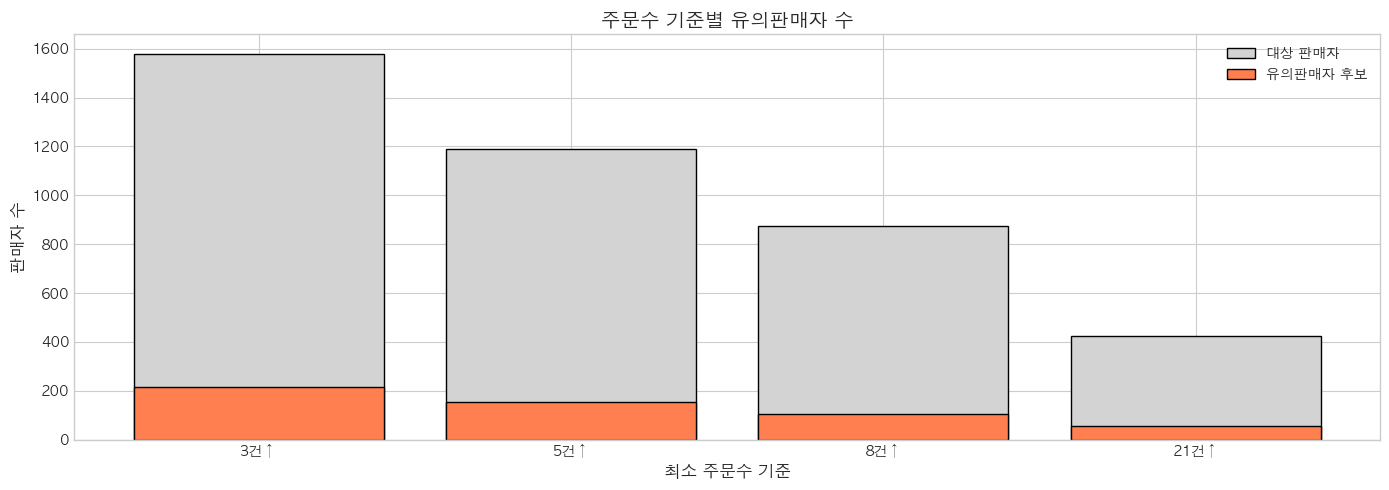

In [ ]:
# 주문수 기준별 유의판매자 식별

MIN_ORDERS_LIST = [3, 5, 8, 21]

results = []
for min_orders in MIN_ORDERS_LIST:
    reliable = seller_order_counts[seller_order_counts['주문수'] >= min_orders].copy()
    
    # 평균 별점 하위 10% 기준
    low_rating_th = reliable['평균별점'].quantile(0.10)
    # 1,2점 비율 상위 10% 기준
    high_low_review_th = reliable['low_review_ratio'].quantile(0.90)
    
    # 유의판매자 후보
    concern = reliable[
        (reliable['평균별점'] <= low_rating_th) |
        (reliable['low_review_ratio'] >= high_low_review_th)
    ]
    
    results.append({
        '최소_주문수': min_orders,
        '대상_판매자수': len(reliable),
        '평균별점_하위10%_기준': round(low_rating_th, 2),
        '1,2점비율_상위10%_기준': f"{high_low_review_th:.1%}",
        '유의판매자_후보수': len(concern),
        '유의판매자_비율': f"{len(concern)/len(reliable)*100:.1f}%"
    })

results_df = pd.DataFrame(results)
print("\n주문수 기준별 유의판매자 비교:")
display(results_df)

# 시각화
fig, ax2 = plt.subplots(figsize=(14, 5))

x_labels = [f'{r["최소_주문수"]}건↑' for r in results]
concern_counts = [r['유의판매자_후보수'] for r in results]
total_counts = [r['대상_판매자수'] for r in results]
ax2.bar(x_labels, total_counts, color='lightgray', edgecolor='black', label='대상 판매자')
ax2.bar(x_labels, concern_counts, color='coral', edgecolor='black', label='유의판매자 후보')
ax2.set_xlabel('최소 주문수 기준', fontsize=12)
ax2.set_ylabel('판매자 수', fontsize=12)
ax2.set_title('주문수 기준별 유의판매자 수', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [420]:
# ==========================================
# 최종 주문수 기준 유의판매자 식별 (선택: 5건 이상)
# ==========================================
print("=" * 70)
print("주문수 기준 유의판매자 식별")
print("=" * 70)

MIN_ORDERS = 21  # 텍스트 리뷰가 있는 주문 5건 이상
reliable_sellers_order = seller_order_counts[seller_order_counts['주문수'] >= MIN_ORDERS].copy()

print(f"최소 {MIN_ORDERS}건 이상 주문 보유 판매자: {len(reliable_sellers_order):,}명")

# 평균 별점 하위 10% 기준
low_rating_threshold_order = reliable_sellers_order['평균별점'].quantile(0.10)
# 1,2점 비율 상위 10% 기준
high_low_review_threshold_order = reliable_sellers_order['low_review_ratio'].quantile(0.90)

print(f"\n기준값:")
print(f"  - 평균별점 하위 10% 기준: {low_rating_threshold_order:.2f}점 이하")
print(f"  - 1,2점 비율 상위 10% 기준: {high_low_review_threshold_order:.1%} 이상")

# 유의판매자 후보
concern_sellers_review_order = reliable_sellers_order[
    (reliable_sellers_order['평균별점'] <= low_rating_threshold_order) &
    (reliable_sellers_order['low_review_ratio'] >= high_low_review_threshold_order)
].copy()

print(f"\n유의판매자 후보 (주문수 기준): {len(concern_sellers_review_order):,}명")
print(f"  - 평균별점 하위 10%: {(reliable_sellers_order['평균별점'] <= low_rating_threshold_order).sum():,}명")
print(f"  - 1,2점 비율 상위 10%: {(reliable_sellers_order['low_review_ratio'] >= high_low_review_threshold_order).sum():,}명")

# 상위 10 유의판매자 (평균별점 기준)
print(f"\n평균별점이 가장 낮은 판매자 TOP 10 (주문수 {MIN_ORDERS}건 이상)")
display(concern_sellers_review_order.nsmallest(10, '평균별점')[['seller_id', '주문수', '리뷰수', '평균별점', 'low_review_ratio', '별점_1점', '별점_2점']])


주문수 기준 유의판매자 식별
최소 21건 이상 주문 보유 판매자: 426명

기준값:
  - 평균별점 하위 10% 기준: 3.04점 이하
  - 1,2점 비율 상위 10% 기준: 54.2% 이상

유의판매자 후보 (주문수 기준): 32명
  - 평균별점 하위 10%: 43명
  - 1,2점 비율 상위 10%: 43명

평균별점이 가장 낮은 판매자 TOP 10 (주문수 21건 이상)


,seller_id,주문수,리뷰수,평균별점,low_review_ratio,별점_1점,별점_2점
281,1ca7077d890b907f89be8c954a02686a,76,76,1.451613,1.052632,73,7
1732,ad781527c93d00d89a11eecd9dcad7c1,22,22,1.909091,0.727273,13,3
969,602044f2c16190c2c6e45eb35c2e21cb,21,22,2.000000,1.000000,19,3
463,2eb70248d66e0e3ef83659f71b244378,130,131,2.021739,0.732824,75,21
1344,8444e55c1f13cd5c179851e5ca5ebd00,48,48,2.294118,0.666667,30,2
846,54965bbe3e4f07ae045b90b0b8541f52,42,42,2.304348,0.690476,26,3
1449,8e6d7754bc7e0f22c96d255ebda59eba,35,35,2.352941,0.885714,28,3
1123,6fd52c528dcb38be2eea044946b811f8,30,30,2.361111,0.800000,19,5
1516,95f83f51203c626648c875dd41874c7f,23,24,2.394737,1.083333,16,10
1867,bbad7e518d7af88a0897397ffdca1979,36,36,2.413043,0.777778,26,2


---
## 유의판매자 기준 2: 제품 상세정보 부실 (사진/설명 없음)


In [421]:
# 제품 상세정보 분석 (사진 개수, 설명 길이)
print("=" * 70)
print("유의판매자 기준 2: 제품 상세정보 부실 (사진/설명 없음)")
print("=" * 70)

# 상품 정보 컬럼 확인
print("\n상품 정보 컬럼:")
print(products.columns.tolist())

# 상품별 정보 확인
print(f"\n상품 상세정보 결측치:")
print(f"  - product_name_lenght (이름 길이): {products['product_name_lenght'].isna().sum():,}건")
print(f"  - product_description_lenght (설명 길이): {products['product_description_lenght'].isna().sum():,}건")
print(f"  - product_photos_qty (사진 개수): {products['product_photos_qty'].isna().sum():,}건")

# 사진 개수 0개인 상품
no_photo = products[products['product_photos_qty'] == 0]
print(f"\n사진 0개인 상품: {len(no_photo):,}개")

# 설명 없는 상품 (NaN 또는 0)
no_description = products[(products['product_description_lenght'].isna()) | (products['product_description_lenght'] == 0)]
print(f"설명 없는 상품: {len(no_description):,}개")


유의판매자 기준 2: 제품 상세정보 부실 (사진/설명 없음)

상품 정보 컬럼:
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_category_name_english']

상품 상세정보 결측치:
  - product_name_lenght (이름 길이): 610건
  - product_description_lenght (설명 길이): 610건
  - product_photos_qty (사진 개수): 610건

사진 0개인 상품: 0개
설명 없는 상품: 610개


In [422]:
# 판매자별 제품 상세정보 분석
# 판매자별 상품 정보 집계
seller_product_info = df_analysis.groupby('seller_id').agg(
    총_상품수=('product_id', 'nunique'),
    평균_사진수=('product_photos_qty', 'mean'),
    평균_설명길이=('product_description_lenght', 'mean'),
    사진없는_상품수=('product_photos_qty', lambda x: (x == 0).sum()),
    설명없는_상품수=('product_description_lenght', lambda x: (x.isna() | (x == 0)).sum()),
).reset_index()

# 비율 계산
seller_product_info['사진없는_비율'] = seller_product_info['사진없는_상품수'] / seller_product_info['총_상품수']
seller_product_info['설명없는_비율'] = seller_product_info['설명없는_상품수'] / seller_product_info['총_상품수']

print("판매자별 제품 상세정보 통계:")
display(seller_product_info[['평균_사진수', '평균_설명길이', '사진없는_비율', '설명없는_비율']].describe())

# 유의판매자 후보 (제품 정보 부실)
# 기준: 평균 사진 수 하위 10% 또는 평균 설명 길이 하위 10%
photo_threshold = seller_product_info['평균_사진수'].quantile(0.10)
desc_threshold = seller_product_info['평균_설명길이'].quantile(0.10)

print(f"\n기준값:")
print(f"  - 평균 설명 길이 하위 10%: {desc_threshold:.0f}자 이하")

concern_sellers_product = seller_product_info[
    (seller_product_info['평균_사진수'] <= photo_threshold) &
    (seller_product_info['평균_설명길이'] <= desc_threshold)
].copy()

print(f"\n유의판매자 후보 (제품정보 부실): {len(concern_sellers_product):,}명")


판매자별 제품 상세정보 통계:


,평균_사진수,평균_설명길이,사진없는_비율,설명없는_비율
count,2504.000000,2504.000000,2555.0,2555.000000
mean,2.236477,856.793440,0.0,0.059407
std,1.497239,620.178161,0.0,0.363900
min,1.000000,47.000000,0.0,0.000000
25%,1.000000,437.000000,0.0,0.000000
50%,1.877976,694.166667,0.0,0.000000
75%,3.000000,1080.650000,0.0,0.000000
max,15.000000,3992.000000,0.0,8.933333



기준값:
  - 평균 설명 길이 하위 10%: 277자 이하

유의판매자 후보 (제품정보 부실): 105명


---
## 유의판매자 기준 3: 주문 방치 (주문 접수 후 n일 이상 출고 안됨)


In [423]:
# 주문 방치 분석 (주문 승인 -> 운송업체 인수)
print("=" * 70)
print("유의판매자 기준 3: 주문 방치 (n일 이상 출고 안됨)")
print("=" * 70)

# 출고 소요 시간 계산 (주문 승인 → 운송업체 인수)
df_analysis['shipping_time_days'] = (
    df_analysis['order_delivered_carrier_date'] - df_analysis['order_approved_at']
).dt.total_seconds() / (24 * 60 * 60)

# 유효한 데이터만 필터링
shipping_valid = df_analysis[
    (df_analysis['shipping_time_days'].notna()) & 
    (df_analysis['shipping_time_days'] >= 0)
].copy()

print(f"\n데이터 수: {len(shipping_valid):,}건")

# 출고 시간 통계
print(f"\n출고 시간 통계 (일):")
display(shipping_valid['shipping_time_days'].describe(percentiles=[.25, .5, .75, .9, .95]))

# 3.7일 이상 방치된 주문( 90%가 6.2일 이상)
NEGLECT_THRESHOLD = 6.272711
neglected_orders = shipping_valid[shipping_valid['shipping_time_days'] >= NEGLECT_THRESHOLD]

print(f"\n{NEGLECT_THRESHOLD}일 이상 출고 지연 주문: {len(neglected_orders):,}건")
print(f"전체 대비 비율: {len(neglected_orders)/len(shipping_valid)*100:.2f}%")


유의판매자 기준 3: 주문 방치 (n일 이상 출고 안됨)

데이터 수: 47,759건

출고 시간 통계 (일):


count    47759.000000
mean         2.999982
std          3.768150
min          0.000671
25%          0.910174
50%          1.901042
75%          3.743229
90%          6.272711
95%          8.968719
max        125.762569
Name: shipping_time_days, dtype: float64


6.272711일 이상 출고 지연 주문: 4,776건
전체 대비 비율: 10.00%


`(df_analysis['order_delivered_carrier_date'] - df_analysis['order_approved_at']).dt.total_seconds() / (24 * 60 * 60)`

#### [설명] 주문 승인부터 택배사 인계까지 걸린 시간을 '일' 단위로 정밀 계산
1. 두 날짜의 차이(Timedelta)를 구한 뒤
2. `.dt.total_seconds()`로 전체를 '초'로 환산
3. 하루(86,400초)로 나누어 소수점이 포함된 실수 형태로 변환
- `.dt.days`를 사용하면 시간 단위가 버림(1.9일 -> 1일)되어 오차가 발생하므로 이 방식 권장

In [424]:
# 판매자별 주문 방치 통계

# 먼저 주문 단위로 방치 여부 판단 (한 주문에 여러 아이템이 있을 수 있으므로)
# 주문별 최대 출고 시간으로 방치 여부 판단
order_shipping = shipping_valid.groupby(['seller_id', 'order_id']).agg(
    출고시간=('shipping_time_days', 'max')  # 주문 내 최대 출고 시간
).reset_index()
order_shipping['방치여부'] = (order_shipping['출고시간'] >= NEGLECT_THRESHOLD).astype(int)

# 판매자별 출고 시간 통계 (주문 단위)
seller_shipping_stats = order_shipping.groupby('seller_id').agg(
    총_주문수=('order_id', 'nunique'),
    평균_출고시간=('출고시간', 'mean'),
    최대_출고시간=('출고시간', 'max'),
    방치_주문수=('방치여부', 'sum')  # 방치된 주문 수 (고유 주문 단위)
).reset_index()

seller_shipping_stats['방치_비율'] = seller_shipping_stats['방치_주문수'] / seller_shipping_stats['총_주문수']

print(f"판매자별 출고 시간 통계:")
display(seller_shipping_stats[['평균_출고시간', '최대_출고시간', '방치_비율']].describe())


판매자별 출고 시간 통계:


,평균_출고시간,최대_출고시간,방치_비율
count,2447.000000,2447.000000,2447.000000
mean,3.201859,6.684355,0.108860
std,4.194942,8.020186,0.242346
min,0.036100,0.036100,0.000000
25%,1.331540,2.260718,0.000000
50%,2.092563,4.150081,0.000000
75%,3.638333,7.345307,0.072376
max,101.361285,125.762569,1.000000


In [425]:
# 유의판매자 후보 (주문 방치 기준)

# 방치 이력이 있는 판매자
concern_sellers_neglect = seller_shipping_stats[seller_shipping_stats['방치_주문수'] > 0].copy()

print(f"\n{NEGLECT_THRESHOLD}일 이상 방치 이력이 있는 판매자: {len(concern_sellers_neglect):,}명")

# 심각한 방치 판매자 (2회 이상 또는 비율 10% 이상)
severe_neglect = seller_shipping_stats[
    (seller_shipping_stats['방치_주문수'] >= 2) & 
    (seller_shipping_stats['방치_비율'] >= 0.1)
]
print(f"심각한 방치 판매자 (2회이상 + 10%이상): {len(severe_neglect):,}명")

# 상위 10 방치 판매자
print(f"\n방치 주문이 가장 많은 판매자 TOP 10:")
display(concern_sellers_neglect.nlargest(20, '방치_주문수')[['seller_id', '총_주문수', '평균_출고시간', '방치_주문수', '방치_비율']])



6.272711일 이상 방치 이력이 있는 판매자: 775명
심각한 방치 판매자 (2회이상 + 10%이상): 316명

방치 주문이 가장 많은 판매자 TOP 10:


,seller_id,총_주문수,평균_출고시간,방치_주문수,방치_비율
1218,7c67e1448b00f6e969d365cea6b010ab,498,11.801436,428,0.859438
447,2eb70248d66e0e3ef83659f71b244378,119,10.573508,79,0.663866
67,06a2c3af7b3aee5d69171b0e14f0ee87,210,4.891744,70,0.333333
1305,85d9eb9ddc5d00ca9336a2219c97bb13,166,6.556570,64,0.385542
2022,d2374cbcbb3ca4ab1086534108cc3ab7,242,4.436903,58,0.239669
1326,88460e8ebdecbfecb5f9601833981930,127,7.439908,56,0.440945
299,1f50f920176fa81dab994f9023523100,673,3.417779,55,0.081724
159,1025f0e2d44d7041d6cf58b6550e0bfa,402,3.737686,49,0.121891
318,213b25e6f54661939f11710a6fddb871,69,7.099751,42,0.608696
708,4a3ca9315b744ce9f8e9374361493884,927,2.350379,40,0.043150


In [426]:
# 기간별(월별) 평균 방치 기간 분석
print("=" * 70)
print("기간별(월별) 평균 출고 시간 및 방치 비율 추이")
print("=" * 70)

# shipping_valid에 주문 월 정보 추가
shipping_valid['주문월'] = shipping_valid['order_approved_at'].dt.to_period('M')

# 월별 출고 시간 통계
monthly_shipping = shipping_valid.groupby('주문월').agg(
    주문수=('order_id', 'nunique'),
    평균_출고시간=('shipping_time_days', 'mean'),
    중앙값_출고시간=('shipping_time_days', 'median'),
    방치_주문수=('shipping_time_days', lambda x: (x >= NEGLECT_THRESHOLD).sum())
).reset_index()

monthly_shipping['방치_비율'] = monthly_shipping['방치_주문수'] / monthly_shipping['주문수']
monthly_shipping['주문월_str'] = monthly_shipping['주문월'].astype(str)

print("\n월별 출고 시간 통계:")
display(monthly_shipping)

기간별(월별) 평균 출고 시간 및 방치 비율 추이

월별 출고 시간 통계:


,주문월,주문수,평균_출고시간,중앙값_출고시간,방치_주문수,방치_비율,주문월_str
0,2017-01,333,3.229493,2.445810,44,0.132132,2017-01
1,2017-02,722,3.475274,1.955150,110,0.152355,2017-02
2,2017-03,1087,3.074789,1.858218,136,0.125115,2017-03
3,2017-04,955,3.310707,2.155301,136,0.142408,2017-04
4,2017-05,1445,2.666842,1.702072,155,0.107266,2017-05
5,2017-06,1332,2.987227,1.995775,170,0.127628,2017-06
6,2017-07,1620,2.796692,2.015613,153,0.094444,2017-07
7,2017-08,1697,2.791782,1.973808,162,0.095463,2017-08
8,2017-09,1718,2.882686,2.118270,178,0.103609,2017-09
9,2017-10,1852,3.157361,1.943148,278,0.150108,2017-10


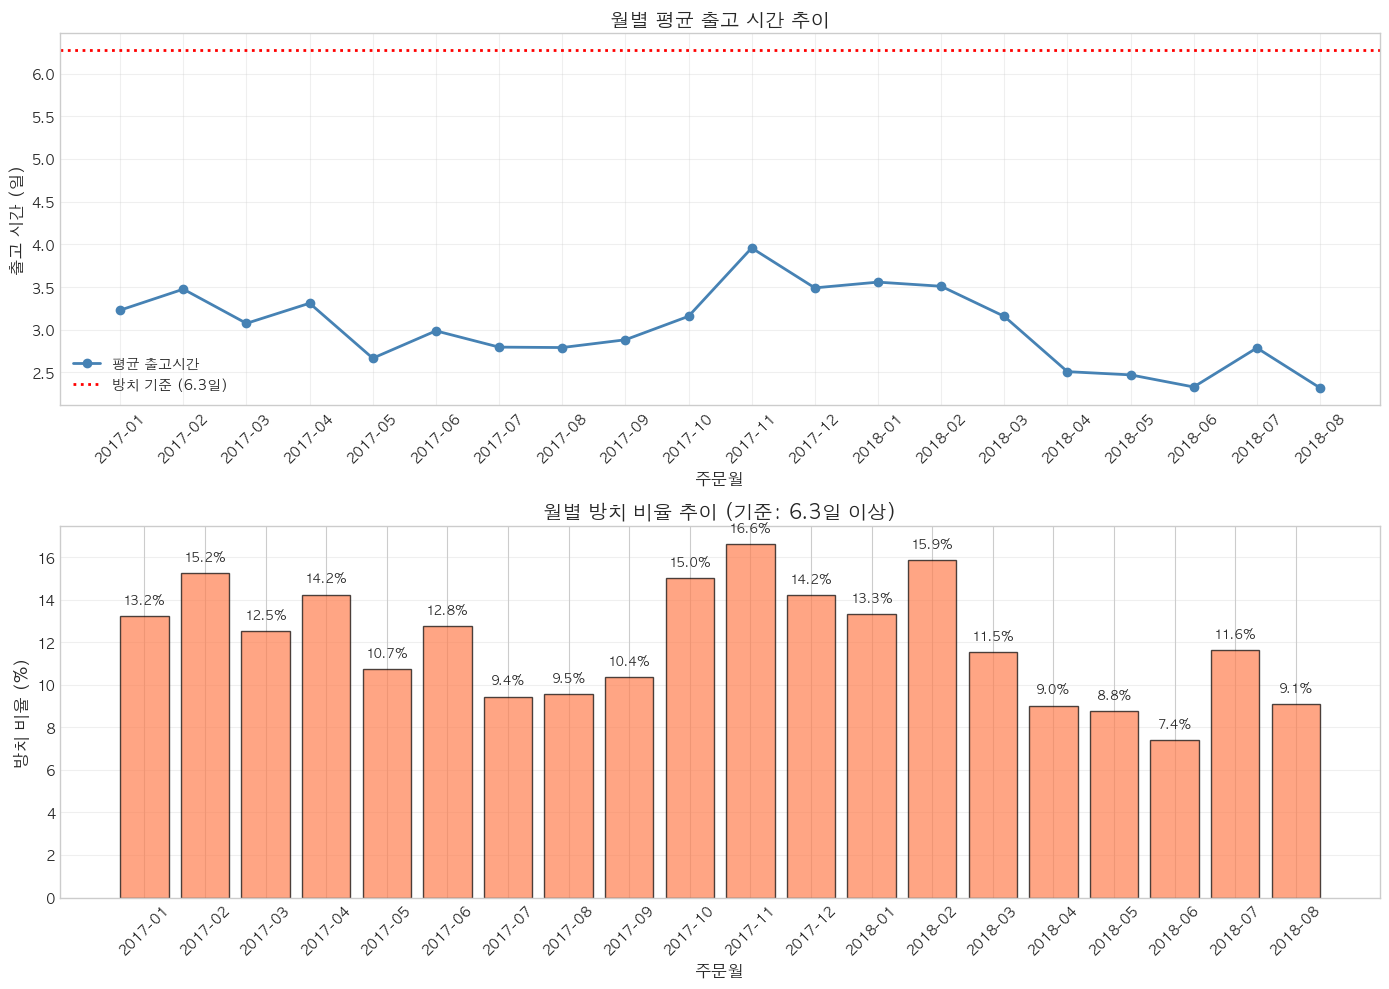

In [427]:
# 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. 월별 평균 출고 시간 추이
ax1 = axes[0]
ax1.plot(monthly_shipping['주문월_str'], monthly_shipping['평균_출고시간'], 
         marker='o', color='steelblue', linewidth=2, label='평균 출고시간')
ax1.axhline(y=NEGLECT_THRESHOLD, color='red', linestyle=':', linewidth=2, label=f'방치 기준 ({NEGLECT_THRESHOLD:.1f}일)')
ax1.set_xlabel('주문월', fontsize=12)
ax1.set_ylabel('출고 시간 (일)', fontsize=12)
ax1.set_title('월별 평균 출고 시간 추이', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 월별 방치 비율 추이
ax2 = axes[1]
bars = ax2.bar(monthly_shipping['주문월_str'], monthly_shipping['방치_비율'] * 100, 
               color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('주문월', fontsize=12)
ax2.set_ylabel('방치 비율 (%)', fontsize=12)
ax2.set_title(f'월별 방치 비율 추이 (기준: {NEGLECT_THRESHOLD:.1f}일 이상)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# 값 표시
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---
## 유의판매자 기준 4: 결제 승인 소요시간 4일 이상


In [428]:
# 결제 승인 소요시간 분석 (주문 -> 승인)
print("=" * 70)
print("유의판매자 기준 4: 결제 승인 소요시간 n일 이상")
print("=" * 70)

# 결제 승인 소요 시간 계산 (주문 -> 승인)
df_analysis['approval_time_days'] = (
    df_analysis['order_approved_at'] - df_analysis['order_purchase_timestamp']
).dt.total_seconds() / (24 * 60 * 60)

# 유효한 데이터만 필터링
approval_valid = df_analysis[
    (df_analysis['approval_time_days'].notna()) & 
    (df_analysis['approval_time_days'] >= 0)
].copy()

print(f"\n데이터 수: {len(approval_valid):,}건")

# 결제 승인 시간 통계
print(f"\n결제 승인 소요시간(주문 -> 승인) 통계 (일):")
display(approval_valid['approval_time_days'].describe(percentiles=[.25, .5, .75, .9, .95]))


# 0.1.430759 이상 소요된 주문
APPROVAL_THRESHOLD = 1.430759
slow_approval = approval_valid[approval_valid['approval_time_days'] >= APPROVAL_THRESHOLD]

print(f"\n{APPROVAL_THRESHOLD}일 이상 승인 지연 주문: {len(slow_approval):,}건")
print(f"전체 대비 비율: {len(slow_approval)/len(approval_valid)*100:.2f}%")


유의판매자 기준 4: 결제 승인 소요시간 n일 이상

데이터 수: 48,523건

결제 승인 소요시간(주문 -> 승인) 통계 (일):


count    48523.000000
mean         0.423199
std          0.940158
min          0.000000
25%          0.009016
50%          0.014549
75%          0.611389
90%          1.430759
95%          1.955243
max         60.452766
Name: approval_time_days, dtype: float64


1.430759일 이상 승인 지연 주문: 4,853건
전체 대비 비율: 10.00%


In [429]:
# 판매자별 결제 승인 소요시간 통계

# 판매자별 승인 시간 통계
seller_approval_stats = approval_valid.groupby('seller_id').agg(
    총_주문수=('order_id', 'nunique'),
    평균_승인시간=('approval_time_days', 'mean'),
    최대_승인시간=('approval_time_days', 'max'),
    지연_주문수=('approval_time_days', lambda x: (x >= APPROVAL_THRESHOLD).sum())
).reset_index()

seller_approval_stats['지연_비율'] = seller_approval_stats['지연_주문수'] / seller_approval_stats['총_주문수']

print("판매자별 결제 승인 시간 통계:")
display(seller_approval_stats[['평균_승인시간', '최대_승인시간', '지연_비율']].describe())

판매자별 결제 승인 시간 통계:


,평균_승인시간,최대_승인시간,지연_비율
count,2555.000000,2555.000000,2555.000000
mean,0.402374,1.504113,0.111714
std,0.563184,2.158817,0.277511
min,0.000000,0.000000,0.000000
25%,0.019809,0.029578,0.000000
50%,0.296747,1.007280,0.000000
75%,0.532226,2.319497,0.125000
max,14.538630,60.452766,6.000000


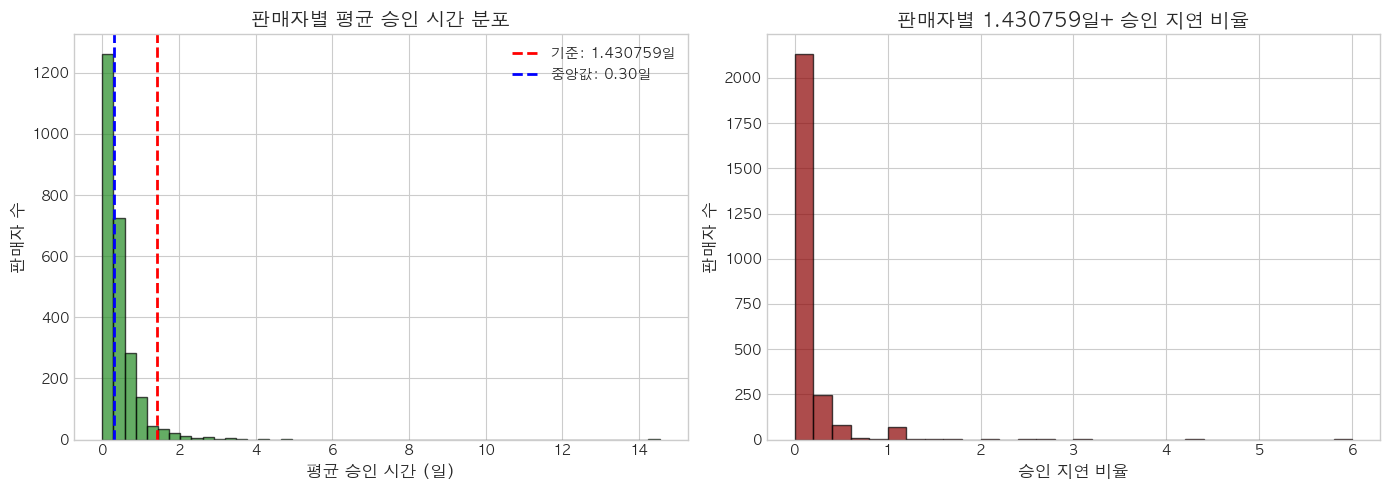

In [430]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 평균 승인 시간 분포 (로그 스케일)
ax1 = axes[0]
ax1.hist(seller_approval_stats['평균_승인시간'], bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
ax1.axvline(APPROVAL_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'기준: {APPROVAL_THRESHOLD}일')
ax1.axvline(seller_approval_stats['평균_승인시간'].median(), color='blue', linestyle='--', linewidth=2, label=f"중앙값: {seller_approval_stats['평균_승인시간'].median():.2f}일")
ax1.set_xlabel('평균 승인 시간 (일)', fontsize=12)
ax1.set_ylabel('판매자 수', fontsize=12)
ax1.set_title('판매자별 평균 승인 시간 분포', fontsize=14, fontweight='bold')
ax1.legend()

# 승인 지연 비율 분포
ax2 = axes[1]
ax2.hist(seller_approval_stats['지연_비율'], bins=30, edgecolor='black', alpha=0.7, color='darkred')
ax2.set_xlabel('승인 지연 비율', fontsize=12)
ax2.set_ylabel('판매자 수', fontsize=12)
ax2.set_title(f'판매자별 {APPROVAL_THRESHOLD}일+ 승인 지연 비율', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [431]:
# 유의판매자 후보 (결제 승인 지연 기준)

# 승인 지연 이력이 있는 판매자
concern_sellers_approval = seller_approval_stats[seller_approval_stats['지연_주문수'] > 0].copy()

print(f"\n{APPROVAL_THRESHOLD}일 이상 승인 지연 이력이 있는 판매자: {len(concern_sellers_approval):,}명")
print(f"전체 판매자 대비: {len(concern_sellers_approval)/len(seller_approval_stats)*100:.1f}%")

# 상위 10 승인 지연 판매자
print(f"\n승인 지연 주문이 가장 많은 판매자 TOP 10:")
display(concern_sellers_approval.nlargest(10, '지연_주문수')[['seller_id', '총_주문수', '평균_승인시간', '지연_주문수', '지연_비율']])


1.430759일 이상 승인 지연 이력이 있는 판매자: 1,050명
전체 판매자 대비: 41.1%

승인 지연 주문이 가장 많은 판매자 TOP 10:


,seller_id,총_주문수,평균_승인시간,지연_주문수,지연_비율
310,1f50f920176fa81dab994f9023523100,673,0.572789,146,0.216939
733,4a3ca9315b744ce9f8e9374361493884,928,0.388136,101,0.108836
1266,7c67e1448b00f6e969d365cea6b010ab,500,0.572756,100,0.200000
163,1025f0e2d44d7041d6cf58b6550e0bfa,402,0.532432,80,0.199005
2054,cc419e0650a3c5ba77189a1882b7556a,725,0.437557,80,0.110345
1015,6560211a19b47992c3666cc44a7e94c0,878,0.358890,75,0.085421
1510,955fee9216a65b617aa5c0531780ce60,501,0.474437,70,0.139721
2189,da8622b14eb17ae2831f4ac5b9dab84a,504,0.453957,69,0.136905
2345,ea8482cd71df3c1969d7b9473ff13abc,511,0.444693,58,0.113503
1241,7a67c85e85bb2ce8582c35f2203ad736,490,0.381385,47,0.095918


In [432]:
# 주문방치 & 승인지연 횟수별 판매자 수 분석
print("=" * 70)
print("주문방치 & 승인지연 횟수별 판매자 수")
print("=" * 70)

# 주문방치 횟수별 판매자 수 (방치 이력이 있는 판매자만)
neglect_counts = concern_sellers_neglect['방치_주문수'].value_counts().sort_index()
print(f"\n[주문방치 횟수별 판매자 수] (총 {len(concern_sellers_neglect):,}명)")
print("-" * 40)
for count, num_sellers in neglect_counts.items():
    print(f"  {int(count)}회 방치: {num_sellers:,}명")

# 승인지연 횟수별 판매자 수 (지연 이력이 있는 판매자만)
approval_counts = concern_sellers_approval['지연_주문수'].value_counts().sort_index()
print(f"\n[승인지연 횟수별 판매자 수] (총 {len(concern_sellers_approval):,}명)")
print("-" * 40)
for count, num_sellers in approval_counts.items():
    print(f"  {int(count)}회 지연: {num_sellers:,}명")

# 구간별 요약
print("\n" + "=" * 70)
print("구간별 요약")
print("=" * 70)

# 주문방치 구간별
print("\n[주문방치 구간별]")
neglect_bins = pd.cut(concern_sellers_neglect['방치_주문수'], 
                      bins=[0, 1, 2, 5, 10, float('inf')], 
                      labels=['1회', '2회', '3~5회', '6~10회', '10회 초과'],
                      right=True)
print(neglect_bins.value_counts().sort_index())

# 승인지연 구간별
print("\n[승인지연 구간별]")
approval_bins = pd.cut(concern_sellers_approval['지연_주문수'], 
                       bins=[0, 1, 2, 5, 10, float('inf')], 
                       labels=['1회', '2회', '3~5회', '6~10회', '10회 초과'],
                       right=True)
print(approval_bins.value_counts().sort_index())

# 분위수 분석 (25, 50, 75, 90, 95%)
print("\n" + "=" * 70)
print("분위수 분석 (25%, 50%, 75%, 90%, 95%)")
print("=" * 70)

# 주문방치 횟수 분위수
print("\n[주문방치 횟수 분위수]")
neglect_quantiles = concern_sellers_neglect['방치_주문수'].quantile([0.25, 0.50, 0.75, 0.90, 0.95])
for q, val in neglect_quantiles.items():
    print(f"  {int(q*100)}%: {val:.1f}회")

# 승인지연 횟수 분위수
print("\n[승인지연 횟수 분위수]")
approval_quantiles = concern_sellers_approval['지연_주문수'].quantile([0.25, 0.50, 0.75, 0.90, 0.95])
for q, val in approval_quantiles.items():
    print(f"  {int(q*100)}%: {val:.1f}회")


주문방치 & 승인지연 횟수별 판매자 수

[주문방치 횟수별 판매자 수] (총 775명)
----------------------------------------
  1회 방치: 364명
  2회 방치: 130명
  3회 방치: 65명
  4회 방치: 28명
  5회 방치: 28명
  6회 방치: 23명
  7회 방치: 20명
  8회 방치: 13명
  9회 방치: 15명
  10회 방치: 13명
  11회 방치: 10명
  12회 방치: 4명
  13회 방치: 6명
  14회 방치: 6명
  15회 방치: 5명
  16회 방치: 6명
  18회 방치: 3명
  19회 방치: 1명
  21회 방치: 1명
  22회 방치: 1명
  23회 방치: 3명
  24회 방치: 4명
  27회 방치: 4명
  28회 방치: 1명
  29회 방치: 2명
  30회 방치: 1명
  31회 방치: 1명
  32회 방치: 1명
  33회 방치: 1명
  34회 방치: 1명
  35회 방치: 3명
  38회 방치: 1명
  40회 방치: 1명
  42회 방치: 1명
  49회 방치: 1명
  55회 방치: 1명
  56회 방치: 1명
  58회 방치: 1명
  64회 방치: 1명
  70회 방치: 1명
  79회 방치: 1명
  428회 방치: 1명

[승인지연 횟수별 판매자 수] (총 1,050명)
----------------------------------------
  1회 지연: 416명
  2회 지연: 203명
  3회 지연: 123명
  4회 지연: 57명
  5회 지연: 54명
  6회 지연: 27명
  7회 지연: 30명
  8회 지연: 15명
  9회 지연: 18명
  10회 지연: 12명
  11회 지연: 16명
  12회 지연: 6명
  13회 지연: 9명
  14회 지연: 6명
  15회 지연: 5명
  16회 지연: 2명
  17회 지연: 5명
  18회 지연: 2명
  19회 지연: 3명
  20회 지연: 4명
  21회 지연: 3명
  22회 지연: 5

---
# 종합 분석: 유의판매자 통합


In [433]:
# 종합: 유의판매자 통합 분석
print("=" * 70)
print("종합 분석: 유의판매자 통합")
print("=" * 70)

# ==========================================
# 주문수 구간별 분위수 기준 설정 (쉽게 변경 가능)
# ==========================================
HIGH_ORDERS_MIN = 21      # 고주문 판매자 최소 주문수
HIGH_ORDERS_QUANTILE = 0.75  # 고주문 판매자 분위수 기준 (75%)

MID_ORDERS_MIN = 8        # 중주문 판매자 최소 주문수
MID_ORDERS_MAX = 20       # 중주문 판매자 최대 주문수
MID_ORDERS_QUANTILE = 0.90   # 중주문 판매자 분위수 기준 (90%)

print(f"\n[분위수 기준 설정]")
print(f"  - 고주문 판매자 ({HIGH_ORDERS_MIN}건↑): {int(HIGH_ORDERS_QUANTILE*100)}% 분위수")
print(f"  - 중주문 판매자 ({MID_ORDERS_MIN}~{MID_ORDERS_MAX}건): {int(MID_ORDERS_QUANTILE*100)}% 분위수")

# ==========================================
# 판매자 그룹 분리
# ==========================================
# 고주문 판매자 (21건 이상)
high_order_sellers = seller_order_counts[seller_order_counts['주문수'] >= HIGH_ORDERS_MIN].copy()
# 중주문 판매자 (8~20건)
mid_order_sellers = seller_order_counts[
    (seller_order_counts['주문수'] >= MID_ORDERS_MIN) & 
    (seller_order_counts['주문수'] <= MID_ORDERS_MAX)
].copy()

print(f"\n[판매자 그룹별 수]")
print(f"  - 고주문 판매자 ({HIGH_ORDERS_MIN}건↑): {len(high_order_sellers):,}명")
print(f"  - 중주문 판매자 ({MID_ORDERS_MIN}~{MID_ORDERS_MAX}건): {len(mid_order_sellers):,}명")

# ==========================================
# 그룹별 유의판매자 기준 계산
# ==========================================
print("\n" + "=" * 70)
print("그룹별 유의판매자 기준값")
print("=" * 70)

# --- 고주문 판매자 기준 (75% 분위수) ---
high_review_low_th = high_order_sellers['평균별점'].quantile(1 - HIGH_ORDERS_QUANTILE)  # 하위 25%
high_review_high_th = high_order_sellers['low_review_ratio'].quantile(HIGH_ORDERS_QUANTILE)  # 상위 25%

# 주문방치/승인지연 기준 (seller_shipping_stats, seller_approval_stats에서 고주문 판매자만)
high_shipping = seller_shipping_stats[seller_shipping_stats['seller_id'].isin(high_order_sellers['seller_id'])]
high_approval = seller_approval_stats[seller_approval_stats['seller_id'].isin(high_order_sellers['seller_id'])]
high_neglect_th = high_shipping['방치_주문수'].quantile(HIGH_ORDERS_QUANTILE)
high_delay_th = high_approval['지연_주문수'].quantile(HIGH_ORDERS_QUANTILE)

# 제품정보 기준
high_product = seller_product_info[seller_product_info['seller_id'].isin(high_order_sellers['seller_id'])]
high_photo_th = high_product['평균_사진수'].quantile(1 - HIGH_ORDERS_QUANTILE)
high_desc_th = high_product['평균_설명길이'].quantile(1 - HIGH_ORDERS_QUANTILE)

print(f"\n[고주문 판매자 기준 ({HIGH_ORDERS_MIN}건↑, {int(HIGH_ORDERS_QUANTILE*100)}% 분위수)]")
print(f"  - 평균별점 하위 {int((1-HIGH_ORDERS_QUANTILE)*100)}%: {high_review_low_th:.2f}점 이하")
print(f"  - 1,2점비율 상위 {int(HIGH_ORDERS_QUANTILE*100)}%: {high_review_high_th:.1%} 이상")
print(f"  - 주문방치 상위 {int(HIGH_ORDERS_QUANTILE*100)}%: {high_neglect_th:.0f}회 이상")
print(f"  - 승인지연 상위 {int(HIGH_ORDERS_QUANTILE*100)}%: {high_delay_th:.0f}회 이상")
print(f"  - 평균사진수 하위 {int((1-HIGH_ORDERS_QUANTILE)*100)}%: {high_photo_th:.1f}개 이하")
print(f"  - 평균설명길이 하위 {int((1-HIGH_ORDERS_QUANTILE)*100)}%: {high_desc_th:.0f}자 이하")

# --- 중주문 판매자 기준 (90% 분위수) ---
mid_review_low_th = mid_order_sellers['평균별점'].quantile(1 - MID_ORDERS_QUANTILE)  # 하위 10%
mid_review_high_th = mid_order_sellers['low_review_ratio'].quantile(MID_ORDERS_QUANTILE)  # 상위 10%

# 주문방치/승인지연 기준
mid_shipping = seller_shipping_stats[seller_shipping_stats['seller_id'].isin(mid_order_sellers['seller_id'])]
mid_approval = seller_approval_stats[seller_approval_stats['seller_id'].isin(mid_order_sellers['seller_id'])]
mid_neglect_th = mid_shipping['방치_주문수'].quantile(MID_ORDERS_QUANTILE)
mid_delay_th = mid_approval['지연_주문수'].quantile(MID_ORDERS_QUANTILE)

# 제품정보 기준
mid_product = seller_product_info[seller_product_info['seller_id'].isin(mid_order_sellers['seller_id'])]
mid_photo_th = mid_product['평균_사진수'].quantile(1 - MID_ORDERS_QUANTILE)
mid_desc_th = mid_product['평균_설명길이'].quantile(1 - MID_ORDERS_QUANTILE)

print(f"\n[중주문 판매자 기준 ({MID_ORDERS_MIN}~{MID_ORDERS_MAX}건, {int(MID_ORDERS_QUANTILE*100)}% 분위수)]")
print(f"  - 평균별점 하위 {int((1-MID_ORDERS_QUANTILE)*100)}%: {mid_review_low_th:.2f}점 이하")
print(f"  - 1,2점비율 상위 {int(MID_ORDERS_QUANTILE*100)}%: {mid_review_high_th:.1%} 이상")
print(f"  - 주문방치 상위 {int(MID_ORDERS_QUANTILE*100)}%: {mid_neglect_th:.0f}회 이상")
print(f"  - 승인지연 상위 {int(MID_ORDERS_QUANTILE*100)}%: {mid_delay_th:.0f}회 이상")
print(f"  - 평균사진수 하위 {int((1-MID_ORDERS_QUANTILE)*100)}%: {mid_photo_th:.1f}개 이하")
print(f"  - 평균설명길이 하위 {int((1-MID_ORDERS_QUANTILE)*100)}%: {mid_desc_th:.0f}자 이하")

# ==========================================
# 그룹별 유의판매자 선정
# ==========================================
print("\n" + "=" * 70)
print("그룹별 유의판매자 선정")
print("=" * 70)

# --- 고주문 판매자 유의판매자 ---
high_concern_review = set(high_order_sellers[
    (high_order_sellers['평균별점'] <= high_review_low_th) &
    (high_order_sellers['low_review_ratio'] >= high_review_high_th)
]['seller_id'])

high_concern_product = set(high_product[
    (high_product['평균_사진수'] <= high_photo_th) &
    (high_product['평균_설명길이'] <= high_desc_th)
]['seller_id'])

high_concern_neglect = set(high_shipping[high_shipping['방치_주문수'] >= high_neglect_th]['seller_id'])
high_concern_delay = set(high_approval[high_approval['지연_주문수'] >= high_delay_th]['seller_id'])

# --- 중주문 판매자 유의판매자 ---
mid_concern_review = set(mid_order_sellers[
    (mid_order_sellers['평균별점'] <= mid_review_low_th) &
    (mid_order_sellers['low_review_ratio'] >= mid_review_high_th)
]['seller_id'])

mid_concern_product = set(mid_product[
    (mid_product['평균_사진수'] <= mid_photo_th) &
    (mid_product['평균_설명길이'] <= mid_desc_th)
]['seller_id'])

mid_concern_neglect = set(mid_shipping[mid_shipping['방치_주문수'] >= mid_neglect_th]['seller_id'])
mid_concern_delay = set(mid_approval[mid_approval['지연_주문수'] >= mid_delay_th]['seller_id'])

# --- 통합  ---
concern_ids = {
    '리뷰점수_낮음': high_concern_review | mid_concern_review,
    '제품정보_부실': high_concern_product | mid_concern_product,
    '주문방치': high_concern_neglect | mid_concern_neglect,
    '승인지연': high_concern_delay | mid_concern_delay,
}

# 그룹별 상세 출력
print(f"\n[고주문 판매자 유의판매자 ({HIGH_ORDERS_MIN}건↑, {int(HIGH_ORDERS_QUANTILE*100)}% 기준)]")
print(f"  - 리뷰점수 낮음: {len(high_concern_review):,}명")
print(f"  - 제품정보 부실: {len(high_concern_product):,}명")
print(f"  - 주문방치: {len(high_concern_neglect):,}명")
print(f"  - 승인지연: {len(high_concern_delay):,}명")

print(f"\n[중주문 판매자 유의판매자 ({MID_ORDERS_MIN}~{MID_ORDERS_MAX}건, {int(MID_ORDERS_QUANTILE*100)}% 기준)]")
print(f"  - 리뷰점수 낮음: {len(mid_concern_review):,}명")
print(f"  - 제품정보 부실: {len(mid_concern_product):,}명")
print(f"  - 주문방치: {len(mid_concern_neglect):,}명")
print(f"  - 승인지연: {len(mid_concern_delay):,}명")

# 기준별 요약
print("\n각 기준별 유의판매자 수:")
print("-" * 50)
for name, ids in concern_ids.items():
    print(f"  {name}: {len(ids):,}명")

# 전체 유의판매자 (1개 이상 기준 해당)
all_concern_ids = set()
for ids in concern_ids.values():
    all_concern_ids.update(ids)

print(f"\n유의판매자 후보 : {len(all_concern_ids):,}명")

종합 분석: 유의판매자 통합

[분위수 기준 설정]
  - 고주문 판매자 (21건↑): 75% 분위수
  - 중주문 판매자 (8~20건): 90% 분위수

[판매자 그룹별 수]
  - 고주문 판매자 (21건↑): 426명
  - 중주문 판매자 (8~20건): 450명

그룹별 유의판매자 기준값

[고주문 판매자 기준 (21건↑, 75% 분위수)]
  - 평균별점 하위 25%: 3.38점 이하
  - 1,2점비율 상위 75%: 39.1% 이상
  - 주문방치 상위 75%: 7회 이상
  - 승인지연 상위 75%: 9회 이상
  - 평균사진수 하위 25%: 1.2개 이하
  - 평균설명길이 하위 25%: 466자 이하

[중주문 판매자 기준 (8~20건, 90% 분위수)]
  - 평균별점 하위 9%: 2.83점 이하
  - 1,2점비율 상위 90%: 60.2% 이상
  - 주문방치 상위 90%: 3회 이상
  - 승인지연 상위 90%: 3회 이상
  - 평균사진수 하위 9%: 1.0개 이하
  - 평균설명길이 하위 9%: 320자 이하

그룹별 유의판매자 선정

[고주문 판매자 유의판매자 (21건↑, 75% 기준)]
  - 리뷰점수 낮음: 91명
  - 제품정보 부실: 36명
  - 주문방치: 118명
  - 승인지연: 121명

[중주문 판매자 유의판매자 (8~20건, 90% 기준)]
  - 리뷰점수 낮음: 35명
  - 제품정보 부실: 21명
  - 주문방치: 45명
  - 승인지연: 78명

각 기준별 유의판매자 수:
--------------------------------------------------
  리뷰점수_낮음: 126명
  제품정보_부실: 57명
  주문방치: 163명
  승인지연: 199명

유의판매자 후보 : 389명


In [434]:
# 판매자별 해당 기준 수 분석
all_sellers = df_analysis['seller_id'].unique()

# 판매자별 기준 해당 여부 DataFrame
seller_concern_df = pd.DataFrame({'seller_id': all_sellers})

for name, ids in concern_ids.items():
    seller_concern_df[name] = seller_concern_df['seller_id'].isin(ids).astype(int)

# 해당 기준 수 계산
concern_columns = list(concern_ids.keys())
seller_concern_df['해당_기준수'] = seller_concern_df[concern_columns].sum(axis=1)

# 해당 기준 수별 분포
print("\n판매자별 해당 기준 수 분포:")
display(seller_concern_df['해당_기준수'].value_counts().sort_index())

# 2개 이상 기준 해당 판매자
multi_concern = seller_concern_df[seller_concern_df['해당_기준수'] >= 2]
print(f"\n2개이상 기준 해당 판매자: {len(multi_concern):,}명")

# 3개 이상 기준 해당 판매자 (심각)
severe_concern = seller_concern_df[seller_concern_df['해당_기준수'] >= 3]
print(f"3개이상 기준 해당 판매자 (심각): {len(severe_concern):,}명")


판매자별 해당 기준 수 분포:


해당_기준수
0    2166
1     261
2     103
3      22
4       3
Name: count, dtype: int64


2개이상 기준 해당 판매자: 128명
3개이상 기준 해당 판매자 (심각): 25명


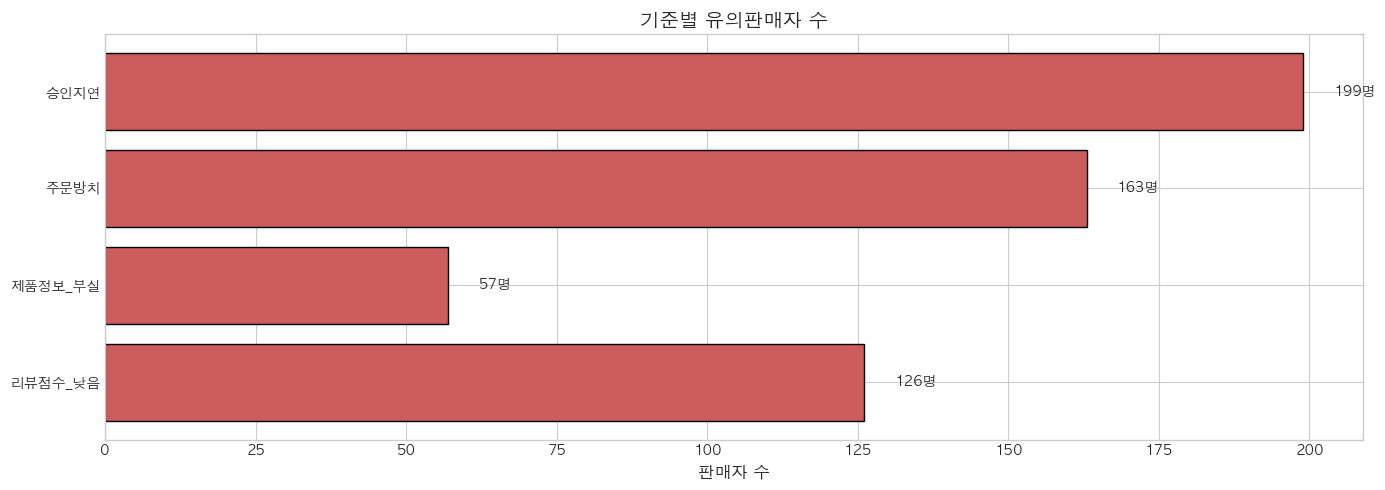

In [435]:
# 시각화: 기준별 유의판매자 분포
fig, ax = plt.subplots(figsize=(14, 5))

criteria_counts = {name: len(ids) for name, ids in concern_ids.items()}

bars = ax.barh(list(criteria_counts.keys()), list(criteria_counts.values()), color='indianred', edgecolor='black')
ax.set_xlabel('판매자 수', fontsize=12)
ax.set_title('기준별 유의판매자 수', fontsize=14, fontweight='bold')

for bar, count in zip(bars, criteria_counts.values()):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f'{count:,}명', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [436]:
# 최종 유의판매자 목록 저장
print("\n" + "=" * 70)
print("최종 유의판매자 분석 결과")
print("=" * 70)

# 2개 이상 기준 해당 판매자 상세
print(f"\n2개이상 기준 해당 유의판매자 TOP 20:")
top_concern = seller_concern_df[seller_concern_df['해당_기준수'] >= 2].nlargest(20, '해당_기준수')
display(top_concern)

# 결과 저장용 DataFrame
final_concern_sellers = seller_concern_df[seller_concern_df['해당_기준수'] >= 1].copy()
print(f"\n최종 유의판매자 후보: {len(final_concern_sellers):,}명")


최종 유의판매자 분석 결과

2개이상 기준 해당 유의판매자 TOP 20:


,seller_id,리뷰점수_낮음,제품정보_부실,주문방치,승인지연,해당_기준수
127,88460e8ebdecbfecb5f9601833981930,1,1,1,1,4
249,d2374cbcbb3ca4ab1086534108cc3ab7,1,1,1,1,4
984,ec4608a1f76453166bb312b2968aeaf4,1,1,1,1,4
6,4a3ca9315b744ce9f8e9374361493884,0,1,1,1,3
20,9c0e69c7bf2619675bbadf47b43f655a,0,1,1,1,3
35,7c67e1448b00f6e969d365cea6b010ab,1,0,1,1,3
61,cca3071e3e9bb7d12640c9fbe2301306,0,1,1,1,3
62,4c2b230173bb36f9b240f2b8ac11786e,1,0,1,1,3
88,1025f0e2d44d7041d6cf58b6550e0bfa,1,0,1,1,3
101,128639473a139ac0f3e5f5ade55873a5,0,1,1,1,3



최종 유의판매자 후보: 389명
